In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("results_full.csv")

metric = "LogLoss"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]
 
method_order = [
    'ConstantPredictor','LogisticRegressor' , 'RandomForestClassifier', 'LGBMClassifier',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'TabPFNClassifier', 'GPBoost_LogLoss'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LogisticRegressor': 'Logistic Regression',
    'TabPFNClassifier': 'TabPFN',
    'GPBoost_LogLoss': 'GP'
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

df = df[df["metric"] == "LogLoss"]
df = df[df["split_method"] == "random_split"]

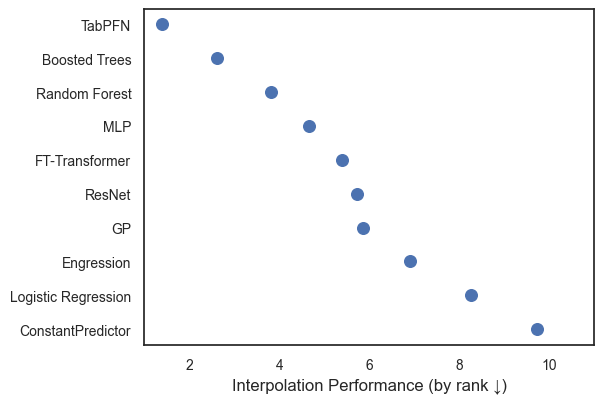

In [4]:
sns.set_theme(style="white", rc={"axes.grid": False})

plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),
    "font.size": 12, "axes.labelsize": 12, "axes.titlesize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10,
})

df["rank"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .rank(ascending=True)
)


overall = (
    df
    .groupby('model')['rank']
    .mean()
    .reset_index(name='Mean')
)


method_order = [
    'ConstantPredictor','LogisticRegressor',
    'RandomForestClassifier',
    'LGBMClassifier',  'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'TabPFNClassifier', 'GPBoost_LogLoss'
]
overall = overall.set_index('model').reindex(method_order).reset_index()

rename_map = {
    'RandomForestClassifier':'Random Forest',
    'LGBMClassifier':       'Boosted Trees',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'LogisticRegressor':     'Logistic Regression',
    'TabPFNClassifier':     'TabPFN',
    'GPBoost_LogLoss':      'GP'
 
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

overall = overall.dropna(subset=['Mean'])                
overall = (overall.groupby('Method', as_index=False)      
                 .agg(Mean=('Mean','mean')))

order = overall.sort_values('Mean')['Method']
y = overall.set_index('Method').loc[order, 'Mean']

fig, ax = plt.subplots()
ax.scatter(y.values, np.arange(len(y)), s=70)
ax.set_yticks(np.arange(len(y)))
ax.set_yticklabels(order)
ax.invert_yaxis()  # best at top
ax.set_xlabel("Interpolation Performance (by rank ↓)")
ax.set_ylabel("")
ax.set_xlim(1.0, float(np.ceil(y.max() + 0.3)))
plt.tight_layout()

import os
os.makedirs("PICTURES", exist_ok=True)
plt.savefig("PICTURES/average_rank_IR_LogLoss.pdf", bbox_inches='tight')
plt.show()
plt.close()

